Happily stolen from https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('aapl.us.txt')

In [3]:
del df['Date'],df['OpenInt'],df['Volume']

In [4]:
df.head()

,Open,High,Low,Close
0,0.42388,0.42902,0.41874,0.42388
1,0.42388,0.42516,0.41366,0.42134
2,0.42516,0.43668,0.42516,0.42902
3,0.42902,0.43157,0.41618,0.41618
4,0.43927,0.44052,0.43927,0.43927


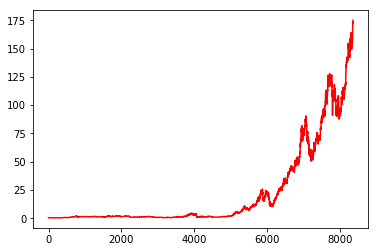

In [5]:
plt.plot(df.Open.values,color='red',label='open')
#a lot more of this preprocessing is in the notebook, feel free to take more!

In [6]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])

In [7]:
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [8]:
df_norm = normalize_data(df)

In [9]:
cols = list(df_norm.columns.values)
print('df_stock.columns.values = ', cols)


df_stock.columns.values =  ['Open', 'High', 'Low', 'Close']


In [10]:
df_norm

,Open,High,Low,Close
0,0.001091,0.001103,0.001082,0.001103
1,0.001091,0.001081,0.001052,0.001088
2,0.001099,0.001146,0.001118,0.001132
3,0.001121,0.001117,0.001067,0.001059
4,0.001179,0.001168,0.001199,0.001190
5,0.001186,0.001256,0.001207,0.001227
6,0.001282,0.001300,0.001302,0.001292
7,0.001282,0.001285,0.001207,0.001197
8,0.001186,0.001198,0.001155,0.001146
9,0.001143,0.001146,0.001163,0.001154


In [11]:
seq_len = 20 # choose sequence length


In [12]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_norm, seq_len)


In [13]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (6676, 19, 4)
y_train.shape =  (6676, 4)
x_valid.shape =  (834, 19, 4)
y_valid.shape =  (834, 4)
x_test.shape =  (834, 19, 4)
y_test.shape =  (834, 4)


This 3rd dimension has to do with the 7 columns in the data, only really care about open, close, high, low, volume... haven't fully cleaned so there is still an array of date and open int which are useless for this problem.

Now the RNN stuff!

In [14]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

In [15]:
# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [16]:
# parameters + hyperparameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 10
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [17]:
# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signatur

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signatur

In [18]:
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.003172/0.107930
5.00 epochs: MSE train/valid = 0.000002/0.000076
9.99 epochs: MSE train/valid = 0.000002/0.000080


In [19]:
np.shape(df_norm)

(8364, 4)

In [20]:
np.shape(y_train)

(6676, 4)

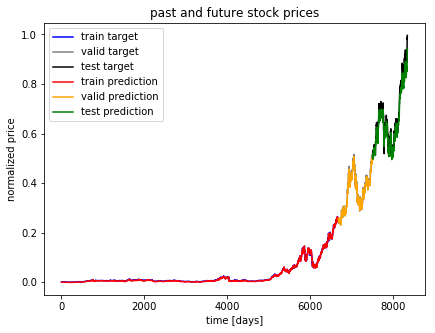

In [21]:
## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,0], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,0],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,0], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,0], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,0], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,0], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');